In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip
import random
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point

In [4]:
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm
from theano_models import data

In [5]:
from sklearn import cross_validation
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float, Boolean
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [7]:
from IPython.display import IFrame
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
tm.inputting_references.update(['to_be_randomized'])
tm.inputting_references, tm.outputting_references

({'extra_inputs',
  'flat',
  'inputs',
  'n_data',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'loglikelihood', 'norm_det', 'norm_dets', 'outputs'})

In [9]:
from schlichtanders.myobjects import NestedNamespace

# Data

    # datasetnames = ["boston", "concrete", "energy", "kin8nm", "naval", "powerplant", "protein", "winered", "yacht", "year"]
    datasetnames = ["boston", "concrete", "energy", "kin8nm", "naval", "powerplant", "winered", "yacht"]

In [10]:
datasetname = "boston"

In [11]:
Z, X = getattr(data, "_" + datasetname)()
# normalization is standard in Probabilistic Backpropagation Paper
X_mean = X.mean(0)
X_std = X.std(0)
X = (X - X_mean) / X_std
Z_mean = Z.mean(0)
Z_std = Z.std(0)
Z = (Z - Z_mean) / Z_std

In [12]:
X, TX, Z, TZ = cross_validation.train_test_split(X, Z, test_size=0.1) # 10% test used in paper
X, VX, Z, VZ = cross_validation.train_test_split(X, Z, test_size=0.1) # 20% validation used in paper

# Hyperparameters

In [13]:
engine = create_engine('sqlite:///hyperparameters_several.db')
Base = declarative_base(bind=engine)

class RandomHyper(Base):
    __tablename__ = datasetname
    id = Column(Integer, primary_key=True)
    
    # hyper parameters:
    datasetname = Column(String)
    max_epochs_without_improvement = Column(Integer)
    average_n = Column(Integer)
    units_per_layer = Column(Integer)
    minus_log_s = Column(Integer)
    batch_size = Column(Integer)
    
    n_normflows = Column(Integer)
    
    opt_identifier = Column(String)
    opt_momentum = Column(Float)
    opt_offset = Column(Float)
    opt_decay = Column(Float)
    opt_step_rate = Column(Float)
    
    # results:
    best_val_loss = Column(Float)
    best_parameters = Column(PickleType, nullable=True)
    train_loss = Column(PickleType)
    val_loss = Column(PickleType)

    def __init__(self):
        self.datasetname = datasetname
        # hyper parameters:
        self.max_epochs_without_improvement = 30
        self.batch_size = random.choice([1,10, 100])
        self.average_n = 1
        self.units_per_layer = 50
        self.minus_log_s = random.choice([1,2,3,4,5,6,7])
        # the prior is learned together with the other models in analogy to the paper Probabilistic Backpropagation
        
        self.n_normflows = random.choice([1,2,3,4,8,32])
        
        self.opt_identifier = random.choice(["adadelta", "adam", "rmsprop"])
        if self.opt_identifier == "adadelta":
            self.opt_momentum = random.choice([np.random.uniform(0, 0.01), np.random.uniform(0.9, 1)])
            self.opt_offset = random.choice([5e-5, 1e-8])
            self.opt_step_rate = random.choice([1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
        elif self.opt_identifier == "adam":
            self.opt_momentum = random.choice([np.random.uniform(0, 0.01), np.random.uniform(0.8, 0.93)])
            self.opt_offset = 10 ** -np.random.uniform(3, 4)
            self.opt_step_rate = random.choice([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
        elif self.opt_identifier == "rmsprop":
            self.opt_momentum = random.choice([np.random.uniform(0.002, 0.008), np.random.uniform(0.9, 1)])
            self.opt_offset = np.random.uniform(0, 0.000045)
            self.opt_step_rate = random.choice([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
        self.opt_decay = np.random.uniform(0.78, 1)
        
        self.init_results()
    
    def init_results(self):
        # extra for being able to reset results for loaded hyperparameters
        self.best_parameters = None
        self.best_val_loss = inf
        self.train_loss = []
        self.val_loss = []

Base.metadata.create_all()
Session = sessionmaker(bind=engine)
sql_session = Session()
hyper = RandomHyper()
hyper.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f73b5a66e10>,
 'average_n': 1,
 'batch_size': 10,
 'best_parameters': None,
 'best_val_loss': inf,
 'datasetname': 'boston',
 'max_epochs_without_improvement': 30,
 'minus_log_s': 5,
 'n_normflows': 1,
 'opt_decay': 0.8240824669002472,
 'opt_identifier': 'rmsprop',
 'opt_momentum': 0.9101160598332435,
 'opt_offset': 9.983247012642478e-06,
 'opt_step_rate': 0.01,
 'train_loss': [],
 'units_per_layer': 50,
 'val_loss': []}

# Model

In [18]:
Flatten = tm.as_proxmodel("to_be_randomized")(tm.prox_flatten)

## data modelling

In [19]:
# this is extremely useful to tell everything the default sizes
input = tm.as_tensor_variable(X[0], name="X")

In [20]:
predictor = dm.Mlp(
    input=input,
    output_size=Z.shape[1],
    output_transfer='identity',
    hidden_sizes=[hyper.units_per_layer]*1,
    hidden_transfers=["rectifier"]*1
)
predictor

Mlp2 { 'inputs': [AffineNonlinear3.X],
  'outputs': AffineNonlinear4.outputs,
  'parameters': [ AffineNonlinear3.weights,
                  AffineNonlinear3.bias,
                  AffineNonlinear4.weights,
                  AffineNonlinear4.bias]}

In [21]:
target_distribution = pm.DiagGaussianNoise(predictor)
target_distribution

DiagGaussianNoise2 { 'inputs': [AffineNonlinear4.outputs],
  'outputs': DiagGaussianNoise2.outputs,
  'parameters': [],
  'parameters_positive': [DiagGaussianNoise2.var]}

In [22]:
targets = tm.Merge(target_distribution, predictor, Flatten(predictor['parameters']))
targets

Merge3 { 'inputs': [AffineNonlinear3.X],
  'outputs': DiagGaussianNoise2.outputs,
  'parameters': [],
  'parameters_positive': [DiagGaussianNoise2.var],
  'to_be_randomized': "AffineNonlinear3.weights:AffineNonlinear3.bias:AffineNonlinear4.weights:AffineNonlinear4.bias"}

## parameter modelling

In [23]:
params_base = pm.Gauss(output_shape=(tm.total_size(targets['to_be_randomized']),))  
# if you want to use size directly, CAUTION, you need to copy before!
# params_base.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
params_base

Gauss { 'inputs': [],
  'outputs': Gauss.outputs,
  'parameters': [Gauss.mean],
  'parameters_positive': [Gauss.var]}

In [24]:
normflows = [dm.PlanarTransform() for _ in range(hyper.n_normflows)]
normflows

[PlanarTransform { 'inputs': [PlanarTransform.inputs.0],
   'norm_det': PlanarTransform.norm_det,
   'outputs': PlanarTransform.outputs,
   'parameters': [PlanarTransform.b, PlanarTransform.w, PlanarTransform._u]}]

In [25]:
params = params_base
for transform in normflows:
    params = tm.normalizing_flow(transform, params)  # returns transform, however with adapted logP    

params

normalized_flow { 'inputs': [],
  'norm_det': PlanarTransform.norm_det,
  'outputs': PlanarTransform.outputs,
  'parameters': [ PlanarTransform.b,
                  PlanarTransform.w,
                  PlanarTransform._u,
                  Gauss.mean],
  'parameters_positive': [Gauss.var]}

## bayes

In [26]:
prior = pm.Gauss(tm.total_size(targets['to_be_randomized']), init_var=np.exp(-2* hyper.minus_log_s))
prior = tm.fix_params(prior)
prior

Gauss2_fixed { 'inputs': [], 'outputs': Gauss2.outputs}

In [27]:
model = tm.variational_bayes(targets, 'to_be_randomized', params, priors=prior)
model

variational_lower_bound { 'inputs': [AffineNonlinear3.X],
  'kl_prior': variational_lower_bound.kl_prior,
  'logposterior': variational_lower_bound.logposterior,
  'logprior': variational_lower_bound.logprior,
  'n_data': variational_lower_bound.n_data,
  'norm_det': PlanarTransform.norm_det,
  'outputs': DiagGaussianNoise2.outputs,
  'parameters': [ PlanarTransform.b,
                  PlanarTransform.w,
                  PlanarTransform._u,
                  Gauss.mean],
  'parameters_positive': [DiagGaussianNoise2.var, Gauss.var]}

In [28]:
# model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
# UncertainWeights uses softplus parameterization
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.softplus, tm.softplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

# Optimizer

In [30]:
loss = tm.loss_variational(model)
tm.reduce_all_identities()
loss

variational_lower_bound.loss_variational { 'inputs': [DiagGaussianNoise2.logP.rv, AffineNonlinear3.X],
  'logposterior': variational_lower_bound.logposterior,
  'logprior': variational_lower_bound.logprior,
  'loss_data': variational_lower_bound.loss_variational.loss_data,
  'loss_regularizer': variational_lower_bound.kl_prior,
  'n_data': variational_lower_bound.n_data,
  'outputs': variational_lower_bound.loss_variational.outputs,
  'parameters': [ PlanarTransform.b_centered,
                  PlanarTransform.w_centered,
                  PlanarTransform._u_centered,
                  Gauss.mean_centered],
  'parameters_positive': [DiagGaussianNoise2.var_reparam, Gauss.var_reparam]}

Climin wants an iterator of (args, kwarsg) as keyword argument "args" (to be passed to the loss function). Concretley, we use an infinite iterator over minibatches.

In [31]:
n_batches = X.shape[0] // hyper.batch_size  # after this many steps we went through the whole data set once
climin_args = izip(izip(chunk(hyper.batch_size, cycle(Z)), chunk(hyper.batch_size, cycle(X))), repeat({}))

def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)
        
assert len(list(weights_regularizer_1epoch())) == n_batches

optimizer_kwargs = tm.numericalize(loss, flat,
    # no mapreduce in analogy to Probabilistic Backpropagation Paper
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(
        weights_regularizer=cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.size, scale=0.01),
#     profile=True,
#     mode='FAST_COMPILE',
)

In [32]:
opt = optimizer(
    identifier=hyper.opt_identifier,
    step_rate=hyper.opt_step_rate,
    momentum=hyper.opt_momentum,
    decay=hyper.opt_decay,
    offset=hyper.opt_offset,
    
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named offset is not expected by <class 'climin.rmsprop.RmsProp'>
  % (i, klass))
/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.rmsprop.RmsProp'>
  % (i, klass))


# Visualized Fit

In [33]:
optimizer_kwargs['num_loss'](opt.wrt, VZ[:10], VX[:10], no_annealing=True)

1742819.4136745152

<IPython.core.display.Javascript object>


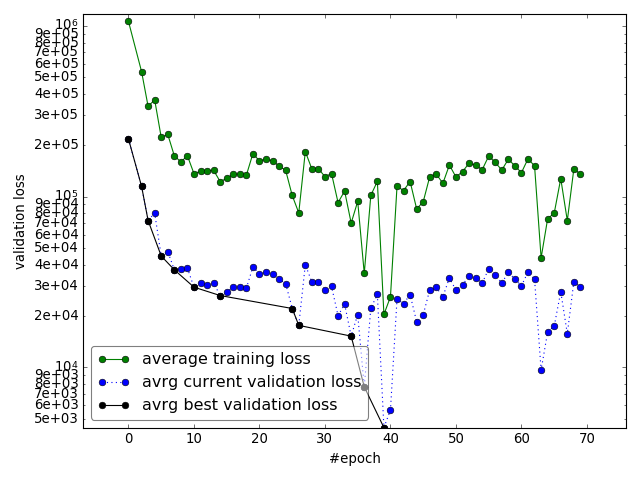

In [35]:
# plot: 
line_train, = plot([], [], 'go-', label="average training loss")
line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
ylabel("validation loss")
xlabel("#epoch")
legend(loc='lower left', fancybox=True, framealpha=0.5)

# start values:
hyper.best_val_loss = optimizer_kwargs['num_loss'](opt.wrt, VZ, VX, no_annealing=True)
training_loss = optimizer_kwargs['num_loss'](opt.wrt, Z[:10], X[:10], no_annealing=True)
start_epoch = opt.n_iter//X.shape[0]

add_point(line_best_val, start_epoch, hyper.best_val_loss)
add_point(line_curr_val, start_epoch, hyper.best_val_loss)
add_point(line_train, start_epoch, training_loss)

In [36]:
last_improvement_epoch = 0
for info in every(n_batches, opt):
    current_epoch = info['n_iter']//n_batches
    if current_epoch - last_improvement_epoch > hyper.max_epochs_without_improvement:
        break
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, VZ, VX, no_annealing=True)
    if val_loss < hyper.best_val_loss:
        last_improvement_epoch = current_epoch
        hyper.best_parameters = opt.wrt
        hyper.best_val_loss = val_loss
        add_point(line_best_val, current_epoch, val_loss)
    hyper.val_loss.append(val_loss)
    add_point(line_curr_val, current_epoch, val_loss)
    
    # visualize training loss for comparison:
    training_loss = optimizer_kwargs['num_loss'](opt.wrt, Z[:10], X[:10], no_annealing=True)
    hyper.train_loss.append(training_loss)
    add_point(line_train, current_epoch, training_loss)
    
#     print info['n_iter'], training_loss, val_loss, best_val_loss

In [37]:
sql_session.add(hyper)
sql_session.commit()

# Performance

TODO: average over predictions

In [39]:
predict = theano.function([flat]+predictor['inputs'], predictor['outputs'])
def mypredict(x):
    return predict(hyper.best_parameters, x)
mypredict(X[0]), Z[0]

(array([ 1.56663782]), array([ 1.32424676], dtype=float32))

In [41]:
PX = np.apply_along_axis(mypredict, 1, X)
PVX = np.apply_along_axis(mypredict, 1, VX)
PTX = np.apply_along_axis(mypredict, 1, TX)

In [42]:
def RMSE(PX, Z):
    return np.sqrt(((PX - Z) ** 2).mean())
def nRMSE(PX, Z):
    return RMSE(PX*Z_std + Z_mean, Z*Z_std + Z_mean)

print '%s RMSE: train/val/test = %g/%g/%g' % (datasetname, nRMSE(PX, Z), nRMSE(PVX, VZ), nRMSE(PTX, TZ))

boston RMSE: train/val/test = 9.34291/6.92728/10.1452
